# Video-CASSIOPE-FAI
***

**Tutoriel :** Ce tutoriel explique comment visualiser les données de la caméra FAI en vidéo.    
**Mission et Instrument :** FAI (Fast Auroral Imager) sur CASSIOPE      
**Objectif astronomique :** Émissions aurorales    
**Outil principal :** Script Python3       
**Niveau du tutoriel :** Intermédiaire 

L'instrument FAI est une camera qui prend des photos principalement d'aurores boréales. L'Université de Calgary crée des vidéos des images du FAI en format .mp4 disponibles sur leurs plateformes : [l'accès HTTP](https://epop-data.phys.ucalgary.ca/) et le [eDex Web](https://edex.phys.ucalgary.ca/#). Cependant, cela pourrait être utile de créer ses propres vidéos avec une palette de couleurs personnalisée. Le script suivant sert à créer une vidéo. Il est important de compiler les cellules pour que le script fonctionne et pour voir la vidéo.

*Note : Ce script n'est pas optimisé pour faire des vidéos le plus rapidement possible.*

## Bibliothèque

Le script qui suit utilise

* *numpy* : opération mathématique et array multidimentionnel
* *h5py* : ouverture de fichier .h5
* *pandas* : structure de dataframe
* *matplotlib* : tracer des figures
* *functools* : outil pour les fonctions
* *basemap* : tracer des cartes
* *datetime* : manipuler des variables de temps
* *re* : faire de la recherche textuelle
* *os* : faire de la recherche dans le système de l'utilisateur
* *IPython* : utiliser python en ligne

In [16]:
import numpy as np
import h5py
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from datetime import datetime as dt

from functools import partial
import re
import os
from IPython.display import HTML

%matplotlib inline

## Configurer la vidéo

Tout d'abord, nous allons créer la figure et la structure de l'image utilisée pour la vidéo. Pour chaque fichier .h5, l'image du FAI sera tracée et la positon de CASSIOPE sera ajoutée sur une carte. On débute en créant une liste avec tous les fichiers que l'on veut utiliser pour la vidéo et on ouvre le premier fichier pour la position initiale de CASSIOPE.

In [17]:
# Dossier où sont tous les fichiers
directory = "FAI_lv1_h5_20190501_150534_151306_6.0.0/"
# Liste de fichiers qu'on veut utiliser pour la vidéo 
# (ici on utilise tous les fichiers entre le 100e fichier et le 160e fichier)
filelist = os.listdir(directory)[100:160]

# Ajouter le répertoire du dossier au nom du fichier
for i in range(len(filelist)):
    filelist[i]=directory+filelist[i]

# Ouvrir le premier fichier et extraire la position initiale de CASSIOPE
with h5py.File(filelist[0], 'r') as f:
    keys = f.attrs.keys()
    values = f.attrs.values()
    attributes = pd.DataFrame(values, keys)
    lonstart = int(attributes.loc['S/C Longitude (°)'])
    latstart = int(attributes.loc['S/C Latitude (°)'])

On peut maintenant définir la figure avec ses axes et les titres.

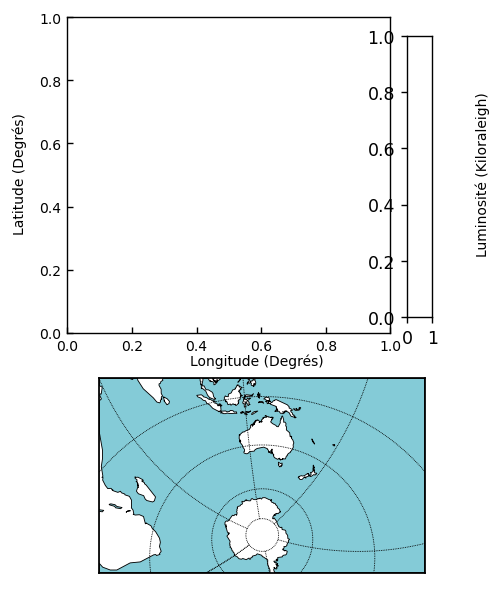

In [18]:
# Créer la figure et la configurer
fig = plt.Figure(figsize=[4,5],dpi=125)
fig.text(0.5, 0.35, 'Longitude (Degrés)', ha='center', va='center',size=8)
fig.text(0.025, 0.65, 'Latitude (Degrés)', ha='center', va='center', rotation='vertical',size=8)
fig.text(0.95, 0.65, 'Luminosité (Kiloraleigh)', ha='center', va='center', rotation='vertical',size=8)
fig.subplots_adjust(left=0.12,bottom=0.01,top=0.90, hspace=0.6)

# Créer les axes pour les différents éléments visuels
ax = fig.add_subplot(5,6,(1,17)) # Axe avec l'image du FAI
ax.tick_params(direction='in', which='both', labelsize=8)

cax=fig.add_axes([0.8, 0.42, 0.05, 0.45]) # L'axe pour la bar de couleur
mapax = fig.add_subplot(5,1,(4,5)) # L'axe avec la carte

# Créer la carte et la configurer
m = Basemap(projection='stere', width=25000000,height=15000000,
                    lon_0=lonstart, lat_0=latstart, ax=mapax)

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='white',lake_color='#84CBD7')
m.drawmapboundary(fill_color='#84CBD7')
m.drawparallels(np.arange(-90.,120.,30.),linewidth=0.5)
m.drawmeridians(np.arange(0.,420.,60.),linewidth=0.5);

fig

## Mettre à jour la figure

Pour créer une figure avec *Matplotlib*, on a besoin d'une fonction qui va mettre à jour la figure principale pour créer plusieurs images. Ensuite, *Matplotlib* va les mettre bout à bout pour créer l'animation. Pour une compilation plus rapide, on va seulement mettre à jour ce qui change, comme l'image, les graduations, les couleurs, la positon de CASSIOPE et le title.

En ce moment, lorsque l'Université de Calgary crée une vidéo, le top 1% des données de lumiminosité de l'image sont en blanc et 0 est en noir. Parfois, on pourrait vouloir des couleurs différentes pour visualiser quelque chose de précis. Le paramètre *pct* de la fonction peut être choisi par l'utilisateur pour varier la distribution des couleurs. Si on veut que le top 10% de la luminosité soit en blanc, alors *pct=0.1*. Si l'utilisateur veut changer les couleurs, voici une liste de [colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) disponibles.

In [19]:
# Fonction utilisée pour mettre à jour la figure utilisée pour la vidéo
# Elle sera utilisée pour tous les fichihers dans filelist
# Paramètres :
# file : le répertoire du fichier (string)
# pct : le % top des valeurs qui sera en blanc (default=0.01) (float)
# cmap : la suite de couleurs à utiliser pour la vidéo (default='binary_r') (string)
# Returne la figure
def updateImage(file,pct=0.01,log=False,cmap='binary_r'):
    
    # Ouvre le fichier courant et extrait
    # les latitudes, longitudes, image and attributs
    with h5py.File(file, 'r') as f:
        image = np.array(f.get('FAI Image'))/1000 # on utilise les kiloraleigh
        lat = np.array(f.get('Pixel Latitudes'))
        lon = np.array(f.get('Pixel Longitudes'))
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys)
        attitude = int(attributes.loc['Attitude Determination Mode'])
        curlon = int(attributes.loc['S/C Longitude (°)'])
        curlat = int(attributes.loc['S/C Latitude (°)'])
    
    # Retirer la dernière ligne et colonne, puisque qu'elles indiquent
    # seulement le coin en bas à droite de l'image
    lat = np.delete(lat,lat.shape[0]-1,0) 
    lat = np.delete(lat,lat.shape[1]-1,1) 
    lon = np.delete(lon,lon.shape[0]-1,0) 
    lon = np.delete(lon,lon.shape[1]-1,1)
    
    # Créer la norme pour la bar de couleur
    if pct==0: # If the percentage is 0, take the max value
        inf = np.nanmax(image)
    else:
        n = int(image.size*pct) # Nombre de top valeurs qu'on veut en blanc
        ind = np.argpartition(image.flatten(), -n)[-n:] # Chercher pour leur index
        inf = min(image.flatten()[ind]) # La valeur minimale des top valeurs
    
    # Norme Logarithmique ou linéaire
    if log :
        norm = colors.LogNorm(vmin=1,vmax=inf)
    else :
        norm = colors.Normalize(vmin=0,vmax=inf)
    
    # Dégager les axes de la figure précédente
    ax.clear()
    cax.cla()
    
    # Ajouter la qualité de l'attiude comme titre
    ax.set_title("Qualité de l'attitude : " + str(attitude), loc='left', fontsize='medium')
    
    # Ajouter l'image FAI et la barre de couleur
    # On utilise la binary colormap de matplotlib (inversée)
    graph = ax.scatter(lon,lat,c=image,cmap=cmap,norm=norm)
    cbar = fig.colorbar(graph,cax=cax,orientation='vertical')
    cbar.ax.tick_params(labelsize=8)
    
    # Ajouter la position de CASSIOPE
    m.plot([lonstart,curlon], [latstart,curlat], color='red', latlon=True, lw=0.7)
    
    # Ajouter le titre de la figure
    match = re.search('(?<=IR_)(\d+)_(\d+)', file)
    d = dt.strptime(match.group(0), '%Y%m%d_%H%M%S')
    fig.suptitle(d)
    
    return(fig)

## Créer et sauvegarder l'animation

Pour créer l'animation, on utilise *animation.FuncAnimation* de *Matplotlib*. La documentation pour cette fonction est [ici](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html).

Pour créer une vidéo de 60 fichier .h5 (ce qui correspond à 60 secondes d'image FAI puisque l'instrument prend 1 image par seconde), le script prend 60-70 secondes à compiler et afficher l'animation. La majorité des sessions du FAI crée entre 450 et 500 fichiers. Avec ce script, cela prend 10-11 minutes pour enregistrer cette animation qui durera 45 secondes avec tous les fichiers.

In [20]:
# Créer une animation avec la valeur par défaut pour pct
ani=animation.FuncAnimation(fig, updateImage, frames=filelist, interval=100, blit=True, cache_frame_data=False)

# Afficher la vidéo dans le notebook (prévoir environ 60-70 secondes)
# HTML(ani.to_html5_video())

# Enregistrer l'animation (prévoir environ 60-70 secondes)
ani.save("Videos/Video_1.mp4")

In [21]:
# Créer une animation avec 10% pour pct
ani=animation.FuncAnimation(fig, partial(updateImage,pct=0.10), 
                            frames=filelist, interval=100, blit=True, cache_frame_data=False)

# Afficher la vidéo dans le notebook (prévoir environ 60-70 secondes)
# HTML(ani.to_html5_video())

# Enregistrer l'animation (prévoir environ 60-70 secondes)
ani.save("Videos/Video_2.mp4")

In [22]:
# Créer une animation avec une norme logarithmique
ani=animation.FuncAnimation(fig, partial(updateImage,pct=0,log=True), 
                            frames=filelist, interval=100, blit=True, cache_frame_data=False)

# Afficher la vidéo dans le notebook (prévoir environ 60-70 secondes)
# HTML(ani.to_html5_video())

# Enregistrer l'animation (prévoir environ 60-70 secondes)
ani.save("Videos/Video_3.mp4")

In [23]:
# Créer une animation de couleur différente
ani=animation.FuncAnimation(fig, partial(updateImage,cmap='gist_rainbow_r'), 
                            frames=filelist, interval=100, blit=True, cache_frame_data=False)

# Afficher la vidéo dans le notebook (prévoir environ 60-70 secondes)
# HTML(ani.to_html5_video())

# Enregistrer l'animation (prévoir environ 60-70 secondes)
ani.save("Videos/Video_4.mp4")